In [27]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

import datetime

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [28]:
mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"

classifier_model = mobilenet_v2


In [29]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

In [48]:
batch_size = 128
img_height = 224
img_width = 224
data_root = r"lung-data"


train_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_root),
  validation_split=0.05,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_root),
  validation_split=0.05,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 7097 files belonging to 4 classes.
Using 6743 files for training.
Found 7097 files belonging to 4 classes.
Using 354 files for validation.


In [32]:
class_names = np.array(train_ds.class_names)
print(class_names)

['COVID19' 'NORMAL' 'PNEUMONIA' 'TUBERCULOSIS']


In [33]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

In [34]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [35]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 224, 224, 3)
(64,)


2022-08-08 03:48:31.225476: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [36]:
result_batch = classifier.predict(train_ds)

2022-08-08 03:48:36.822233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


106/106 [==============================] - 152s 1s/step


In [37]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

feature_extractor_model = mobilenet_v2

In [38]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

In [39]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

2022-08-08 03:52:57.402146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


(64, 1280)


In [40]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_1 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 2,263,108
Trainable params: 5,124
Non-trainable params: 2,257,984
_________________________________________________________________


In [41]:
predictions = model(image_batch)

In [42]:
predictions.shape

TensorShape([64, 4])

In [43]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

In [49]:
NUM_EPOCHS = 10

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=tensorboard_callback)

Epoch 1/10
 6/53 [==>...........................] - ETA: 1:52 - loss: 2.7593 - acc: 0.4102

KeyboardInterrupt: 

In [26]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 1061), started 7:01:36 ago. (Use '!kill 1061' to kill it.)

In [45]:
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

2022-08-08 04:52:43.639400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 405ms/step
['PNEUMONIA' 'PNEUMONIA' 'NORMAL' 'PNEUMONIA' 'NORMAL' 'PNEUMONIA'
 'COVID19' 'PNEUMONIA' 'PNEUMONIA' 'PNEUMONIA' 'PNEUMONIA' 'PNEUMONIA'
 'NORMAL' 'NORMAL' 'NORMAL' 'NORMAL' 'TUBERCULOSIS' 'NORMAL' 'PNEUMONIA'
 'PNEUMONIA' 'PNEUMONIA' 'PNEUMONIA' 'TUBERCULOSIS' 'PNEUMONIA'
 'TUBERCULOSIS' 'PNEUMONIA' 'PNEUMONIA' 'PNEUMONIA' 'NORMAL' 'PNEUMONIA'
 'NORMAL' 'COVID19' 'TUBERCULOSIS' 'PNEUMONIA' 'COVID19' 'PNEUMONIA'
 'PNEUMONIA' 'PNEUMONIA' 'PNEUMONIA' 'NORMAL' 'PNEUMONIA' 'NORMAL'
 'NORMAL' 'NORMAL' 'PNEUMONIA' 'TUBERCULOSIS' 'PNEUMONIA' 'PNEUMONIA'
 'PNEUMONIA' 'NORMAL' 'PNEUMONIA' 'PNEUMONIA' 'PNEUMONIA' 'NORMAL'
 'PNEUMONIA' 'PNEUMONIA' 'COVID19' 'PNEUMONIA' 'PNEUMONIA' 'PNEUMONIA'
 'PNEUMONIA' 'TUBERCULOSIS' 'PNEUMONIA' 'NORMAL']


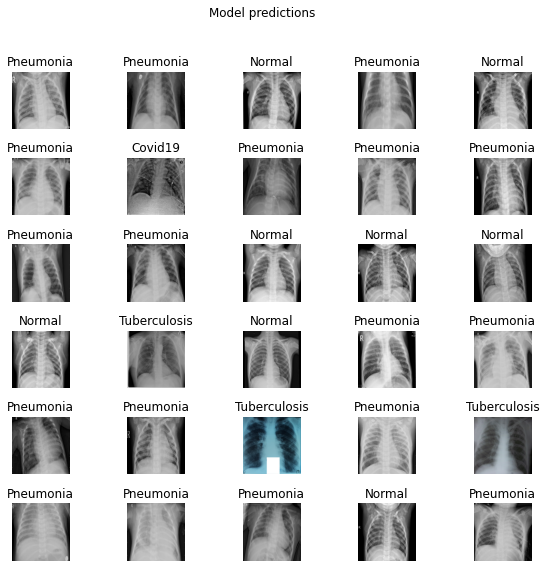

In [46]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

In [47]:
t = time.time()

export_path = r"models/{}".format(int(t))
model.save(export_path)
model.save('model_{}.h5'.format(int(t)))

export_path

'models/1659956154'

In [25]:
import coremltools as cl

clmodel = cl.convert(model)
clmodel.save("mobileLung.mlmodel")

2022-08-08 03:04:14.295975: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2022-08-08 03:04:14.297707: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2022-08-08 03:04:14.302744: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-08 03:04:14.303386: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-08-08 03:04:16.128248: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compile

In [ ]:
reloaded = tf.keras.models.load_model(export_path)

In [ ]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [ ]:
abs(reloaded_result_batch - result_batch).max()

In [ ]:
reloaded_predicted_id = tf.math.argmax(reloaded_result_batch, axis=-1)
reloaded_predicted_label_batch = class_names[reloaded_predicted_id]
print(reloaded_predicted_label_batch)

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(reloaded_predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")